# Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг:
<br>
<ol>
  <li>Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.</li>
  <li>Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).</li>
</ol>

Также абонентам доступен ряд услуг:
<ul>
  <li>Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);</li>
  <li>Выделенная линия технической поддержки (Tech Support);</li>
  <li>Облачное хранилище файлов для резервного копирования данных (Online Backup);</li>
  <li>Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).</li>    
</ul>

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

### Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
<ul>
    <li><code>contract</code> — информация о договорах;</li>
    <li><code>personal</code> — персональные данные клиентов;</li>
    <li><code>internet</code> — информация об интернет-услугах;</li>
    <li><code>phone</code> — информация об услугах телефонии.</li>
</ul>

Таблица <code>telecom.contract</code>
<ul>
    <li><code>customerID</code> — ID абонента;</li>
    <li><code>BeginDate</code> — дата начала действия договора;</li>
    <li><code>EndDate</code> — дата окончания действия договора;</li>
    <li><code>Type</code> — тип оплаты: раз в год-два или ежемесячно;</li>
    <li><code>PaperlessBilling</code> — электронный расчётный лист;</li>
    <li><code>PaymentMethod</code> — тип платежа;</li>
    <li><code>MonthlyCharges</code> — расходы за месяц;</li>
    <li><code>TotalCharges</code> — общие расходы абонента.</li>
</ul>

Таблица <code>personal</code>
<ul>
    <li><code>customerID</code> — ID пользователя;</li>
    <li><code>gender</code> — пол;</li>
    <li><code>SeniorCitizen</code> — является ли абонент пенсионером;</li>
    <li><code>Partner</code> — есть ли у абонента супруг или супруга;</li>
    <li><code>Dependents</code> — есть ли у абонента дети.</li>
</ul>

Таблица <code>telecom.internet</code>
<ul>
    <li><code>customerID</code> — ID пользователя;</li>
    <li><code>InternetService</code> — тип подключения;</li>
    <li><code>OnlineSecurity</code> — блокировка опасных сайтов;</li>
    <li><code>OnlineBackup</code> — облачное хранилище файлов для резервного копирования данных;</li>
    <li><code>DeviceProtection</code> — антивирус;</li>
    <li><code>TechSupport</code> — выделенная линия технической поддержки;</li>
    <li><code>StreamingTV</code> — стриминговое телевидение;</li>
    <li><code>StreamingMovies</code> — каталог фильмов.</li>
</ul>

Таблица <code>telecom.phone</code>
<ul>
    <li><code>customerID</code> — ID пользователя;</li>
    <li><code>MultipleLines</code> — подключение телефона к нескольким линиям одновременно.</li>
</ul>


## Загрузим библиотеки и данные

### Загрузим библиотеки

In [2]:
pip install -U scikit-learn phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
from datetime import timedelta
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

import phik

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### Загрузим данные

In [4]:
db_config = {
    'user': 'praktikum_student',# имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp',# пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,# порт подключения,
    'db': 'data-science-final'# название базы данных,
}

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string)

### Зададим константу

In [7]:
RANDOM_STATE = 131123

## Исследовательский анализ и предоработка данных

### Создадим функции-помощники для анализа исходных данных

Проверка общего состава дф

In [8]:
def check_df(data):
    empty_values = data.isnull().sum()
    duplicate_values = data.duplicated().sum()
    distinct_values = data.nunique()
    explore_data = pd.DataFrame({'column': empty_values.index, 
                                 'empty': empty_values.values, 
                                 'duplicated': duplicate_values, 
                                 'distinct': distinct_values.values})
    return explore_data

Для визуального отображения состава отдельных столбцов (для категориальных значений)

In [9]:
def plot_column_diagram(data, column):
    value_counts = data[column].astype(str).value_counts(dropna=False)
    labels = value_counts.index
    counts = value_counts.values
    
    unique_values = data[column].unique()
    
    string_count = 0
    float_count = 0
    date_count = 0
    integer_count = 0
    other_count = 0
    
    for value in unique_values:
        if pd.api.types.is_string_dtype(value):
            string_count += 1
        elif pd.api.types.is_float_dtype(value):
            float_count += 1
        elif pd.api.types.is_datetime64_any_dtype(value):
            date_count += 1
        elif pd.api.types.is_integer_dtype(value):
            integer_count += 1
        else:
            other_count += 1
            
    summary_table = pd.DataFrame({
        'Data Type': ['String', 'Float', 'Date', 'Integer', 'Other'],
        'Count': [string_count, float_count, date_count, integer_count, other_count]
    })        
    
    fig, ax = plt.subplots()
    
    colors = ['red' if label == 'nan' or label == '0' or label == 'None' else 'black' for label in labels]
    ax.bar(labels, counts, color=colors)
    
    ax.set_xlabel(column)
    ax.set_ylabel('Количество')
    ax.set_title(f'Распределение категориальных значений столбца {column}')
    
    plt.xticks(rotation=90)
    plt.show()
    
    display(summary_table)

### Проверим исходные данные

#### Таблица <code>telecom.contract</code>

In [10]:
query_1 = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(query_1, con = engine)
contract.name = 'contract'

contract.info()
check_df(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


,column,empty,duplicated,distinct
0,customerID,0,0,7043
1,BeginDate,0,0,515
2,EndDate,5174,0,4
3,Type,0,0,3
4,PaperlessBilling,0,0,2
5,PaymentMethod,0,0,4
6,MonthlyCharges,0,0,1585
7,TotalCharges,11,0,6530


In [11]:
display(contract.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


Посмотрим отдельные столбцы

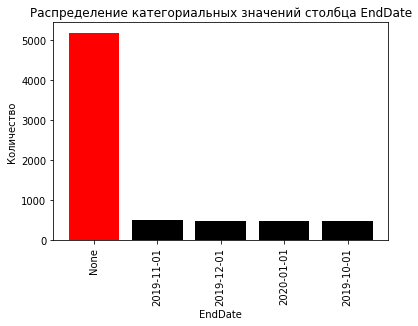

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,5


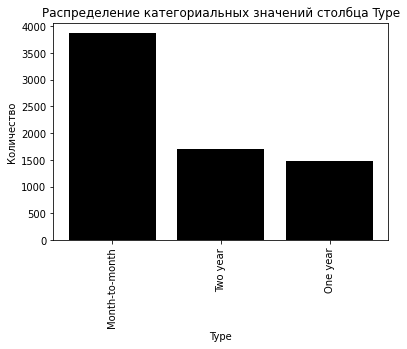

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,3


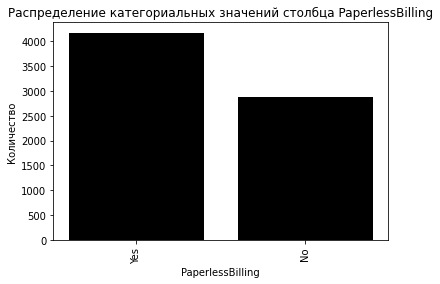

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


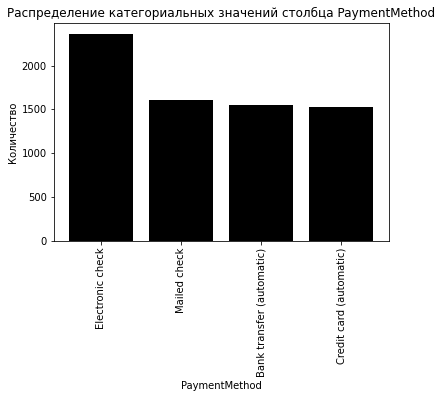

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,4


In [12]:
plot_column_diagram(contract, 'EndDate')
plot_column_diagram(contract, 'Type')
plot_column_diagram(contract, 'PaperlessBilling')
plot_column_diagram(contract, 'PaymentMethod')

In [13]:
contract.shape

(7043, 8)

#### Вывод <code>telecom.contract</code>:

Таблица <code>telecom.contract</code> содержит 8 столбцов, 7043 строки
<br>
<b>MonthlyCharges</b> и <b>TotalCharges</b> единственные два столбца в формате float, остальные в формате object
<br>
Скорее всего <b>BeginDate</b> и <b>EndDate</b> нужно перевести в формат date
<br>
Полных пропусков нет, но есть пустые значения в столбцах <b>EndDate</b> и <b>TotalCharges</b>
<br>
В <b>EndDate</b> слишком много пустых значений. Этот столбик отвечает за дату завершения действия договора, поэтому пустота не означает ошибку, а скорее всего значит то, что договор по прежнему активен

In [14]:
#BeginDate
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d', errors='coerce')

In [15]:
#EndDate
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

In [16]:
display(contract[contract['TotalCharges'].isnull()])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN


In [17]:
#TotalCharges
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)

Проверим

In [18]:
check_df(contract)

,column,empty,duplicated,distinct
0,customerID,0,0,7043
1,BeginDate,0,0,515
2,EndDate,5174,0,4
3,Type,0,0,3
4,PaperlessBilling,0,0,2
5,PaymentMethod,0,0,4
6,MonthlyCharges,0,0,1585
7,TotalCharges,0,0,6531


In [19]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


#### Таблица <code>personal</code>

In [20]:
query_2 = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(query_2, con = engine)
personal.name = 'personal'

personal.info()
check_df(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,column,empty,duplicated,distinct
0,customerID,0,0,7043
1,gender,0,0,2
2,SeniorCitizen,0,0,2
3,Partner,0,0,2
4,Dependents,0,0,2


In [21]:
display(personal.head(10))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Посмотрим отдельные столбцы

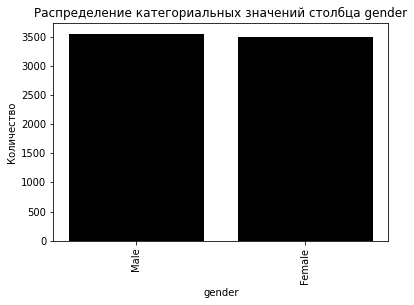

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


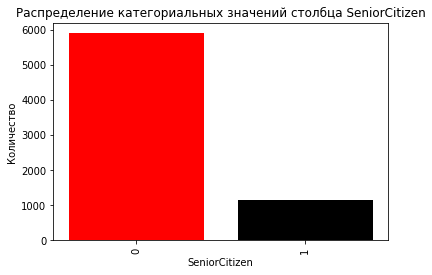

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,2
4,Other,0


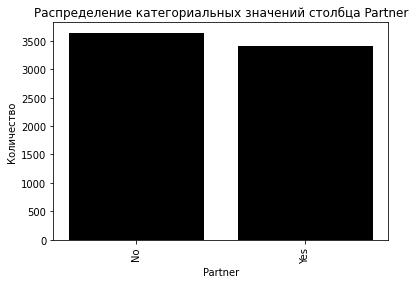

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


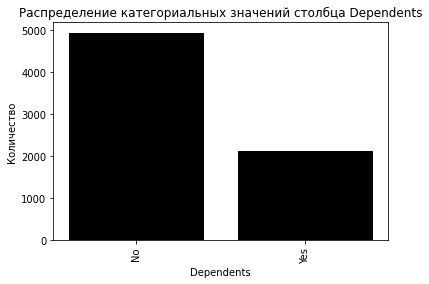

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


In [22]:
plot_column_diagram(personal, 'gender')
plot_column_diagram(personal, 'SeniorCitizen')
plot_column_diagram(personal, 'Partner')
plot_column_diagram(personal, 'Dependents')

In [23]:
personal.shape

(7043, 5)

#### Вывод <code>telecom.personal</code>:

Таблица <code>telecom.personal</code> содержит 5 столбцов, 7043 строки
<br>
Пустот нет
<br>
Все признаки категориальные и содержат по два значения, но <b>SeniorCitizen</b> в формате int, для будущего ohe переведем в object и заменим на 'yes' и 'no'

In [24]:
personal.loc[personal['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
personal.loc[personal['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

Проверим

In [25]:
personal.info()
check_df(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


,column,empty,duplicated,distinct
0,customerID,0,0,7043
1,gender,0,0,2
2,SeniorCitizen,0,0,2
3,Partner,0,0,2
4,Dependents,0,0,2


#### Таблица <code>telecom.internet</code>

In [26]:
query_3 = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(query_3, con = engine)
internet.name = 'internet'

internet.info()
check_df(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


,column,empty,duplicated,distinct
0,c1,0,0,5518
1,c2,0,0,3
2,c3,0,0,3
3,c4,0,0,3
4,c5,0,0,3
5,c6,0,0,3
6,c7,0,0,3
7,c8,0,0,3


In [27]:
display(internet.head(10))

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


нужно повысить заголовки

In [28]:
internet.columns = internet.iloc[0]
internet = internet[1:].reset_index(drop=True)

Посмотрим отдельные столбцы

In [29]:
display(internet.head(10))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


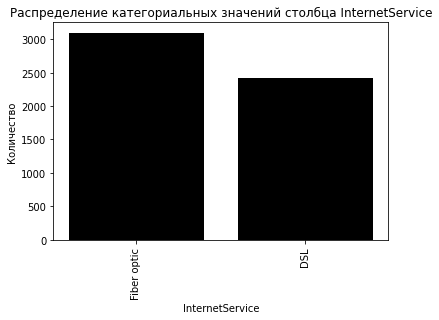

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


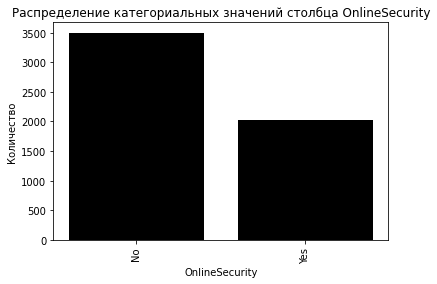

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


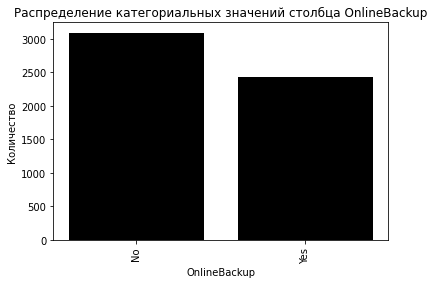

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


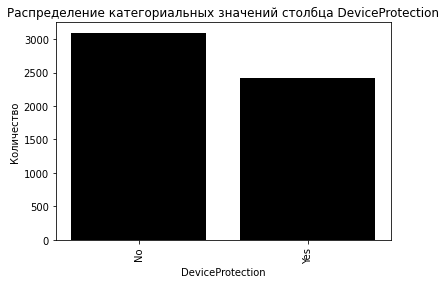

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


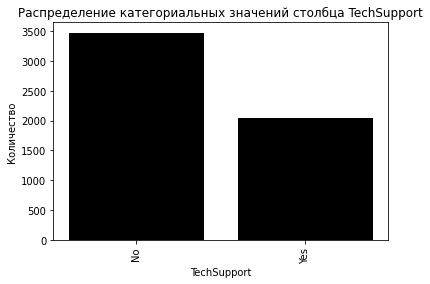

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


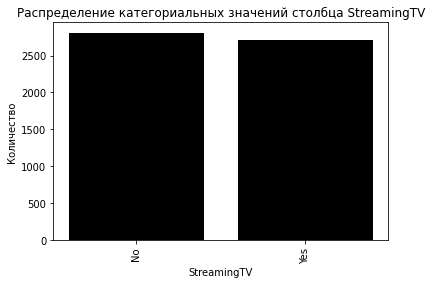

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


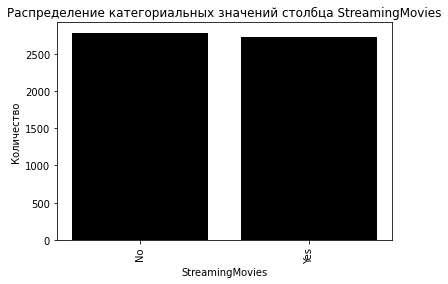

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


In [30]:
plot_column_diagram(internet, 'InternetService')
plot_column_diagram(internet, 'OnlineSecurity')
plot_column_diagram(internet, 'OnlineBackup')
plot_column_diagram(internet, 'DeviceProtection')
plot_column_diagram(internet, 'TechSupport')
plot_column_diagram(internet, 'StreamingTV')
plot_column_diagram(internet, 'StreamingMovies')

In [31]:
internet.shape

(5517, 8)

#### Вывод <code>telecom.internet</code>:

Таблица <code>telecom.internet</code> содержит 8 столбцов, 5517 строки
<br>
Пустот нет
<br>
Все признаки категориальные и содержат по два значения

#### Таблица <code>telecom.phone</code>

In [32]:
query_4 = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(query_4, con = engine)
phone.name = 'phone'

phone.info()
check_df(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,column,empty,duplicated,distinct
0,c1,0,0,6362
1,c2,0,0,3


In [33]:
display(phone.head(10))

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


нужно повысить заголовки

In [34]:
phone.columns = phone.iloc[0]
phone = phone[1:].reset_index(drop=True)

In [35]:
display(phone.head(10))

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


Посмотрим отдельные столбцы

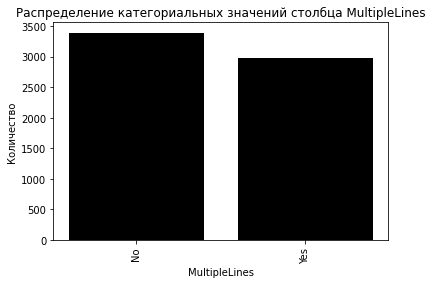

,Data Type,Count
0,String,0
1,Float,0
2,Date,0
3,Integer,0
4,Other,2


In [36]:
plot_column_diagram(phone, 'MultipleLines')

In [37]:
phone.shape

(6361, 2)

#### Вывод <code>telecom.phone</code>:

Таблица <code>telecom.phone</code> содержит 2 столбца, 6361 строки
<br>
Пустот нет
<br>
Все признаки категориальные и содержат по два значения

### Объединим таблицы по ID клиента

Каждому клиенту должно соответствовать одно наблюдение.
<br>
Объединяем по столбцу <b>customerID</b>
<br>
В таблицах <code>contract</code> и <code>personal</code> одинаковое количество строк (и самое большое в сравнении с другими), а значит можно предположить, что они совмещают в себе все уникальные ID пользователей. объединим их и посмотрим увеличится ли количество строк. если нет - это и будет основа объединенного датафрейма

In [38]:
contract.shape

(7043, 8)

In [39]:
personal.shape

(7043, 5)

In [40]:
contract.join(personal.set_index('customerID'), on='customerID', how='outer').shape

(7043, 12)

Отлично! тогда добавляем остальные дф

In [41]:
base_df = contract.join(personal.set_index('customerID'), on='customerID')

In [42]:
base_df = base_df.join(internet.set_index('customerID'), on='customerID', how='left')

In [43]:
base_df = base_df.join(phone.set_index('customerID'), on='customerID', how='left')

In [44]:
check_df(base_df)

,column,empty,duplicated,distinct
0,customerID,0,0,7043
1,BeginDate,0,0,515
2,EndDate,5174,0,4
3,Type,0,0,3
4,PaperlessBilling,0,0,2
5,PaymentMethod,0,0,4
6,MonthlyCharges,0,0,1585
7,TotalCharges,0,0,6531
8,gender,0,0,2
9,SeniorCitizen,0,0,2


### Генерация новых признаков

Определим целевой признак

In [45]:
base_df['target'] = np.where(base_df['EndDate'].isnull(), 0, 1)

Добавим длительность контракта абонента
<br>
Для этого нужно заполнить пустоты <b>EndDate</b> 1 февраля 2020 т.к. это есть в условиях

In [46]:
base_df['EndDate'] = base_df['EndDate'].fillna(pd.to_datetime('2020-02-01', format='%Y-%m-%d'))

Расчитаем длительность в днях

In [47]:
base_df['duration_contract'] = (base_df['EndDate'] - base_df['BeginDate']).dt.components.days

Теперь удалим лишние столбцы, чтобы не мешали при обучении

In [48]:
base_df['MonthlyCharges'].unique().tolist()

[52.55,
 20.25,
 53.85,
 80.85,
 70.7,
 99.65,
 25.75,
 56.05,
 104.8,
 25.35,
 19.7,
 61.9,
 103.7,
 55.2,
 39.65,
 20.15,
 99.35,
 30.2,
 64.7,
 69.7,
 106.35,
 97.85,
 80.65,
 99.1,
 95.45,
 94.4,
 79.35,
 75.15,
 78.95,
 21.05,
 98.5,
 110.0,
 96.75,
 76.5,
 100.25,
 74.4,
 78.05,
 58.6,
 35.45,
 44.35,
 70.45,
 71.15,
 45.65,
 95.0,
 82.4,
 70.9,
 45.3,
 104.4,
 94.85,
 74.45,
 76.45,
 29.95,
 84.5,
 79.25,
 24.8,
 91.0,
 79.9,
 106.6,
 46.0,
 70.15,
 50.05,
 84.6,
 54.4,
 48.55,
 70.4,
 40.2,
 44.6,
 41.15,
 106.9,
 19.35,
 94.45,
 70.6,
 85.4,
 105.05,
 95.15,
 70.0,
 74.5,
 44.85,
 76.1,
 73.6,
 74.9,
 80.6,
 80.3,
 93.15,
 82.45,
 70.35,
 73.85,
 75.8,
 104.6,
 103.4,
 90.4,
 84.8,
 41.9,
 80.25,
 30.75,
 96.5,
 85.65,
 104.95,
 50.65,
 90.85,
 19.95,
 85.45,
 73.95,
 99.45,
 19.9,
 19.6,
 81.35,
 83.3,
 75.3,
 19.4,
 45.4,
 105.9,
 69.55,
 81.05,
 101.15,
 99.8,
 55.95,
 55.0,
 74.7,
 96.1,
 69.0,
 83.55,
 74.35,
 43.75,
 28.45,
 99.7,
 94.1,
 94.2,
 80.5,
 75.2,
 75.6,
 100.

In [49]:
base_df = base_df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [51]:
check_df(base_df)

,column,empty,duplicated,distinct
0,Type,0,0,3
1,PaperlessBilling,0,0,2
2,PaymentMethod,0,0,4
3,MonthlyCharges,0,0,1585
4,TotalCharges,0,0,6531
5,gender,0,0,2
6,SeniorCitizen,0,0,2
7,Partner,0,0,2
8,Dependents,0,0,2
9,InternetService,1526,0,2


по сути у нас остались пустоты из таблиц <code>internet</code> и <code>phone</code>. но я думаю, что именно в нашем датафрейме эти пустоты можно интерпретировать, как 'No'. так и заполним

In [52]:
base_df = base_df.fillna('No')

In [53]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   object 
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   TotalCharges       7043 non-null   float64
 5   gender             7043 non-null   object 
 6   SeniorCitizen      7043 non-null   object 
 7   Partner            7043 non-null   object 
 8   Dependents         7043 non-null   object 
 9   InternetService    7043 non-null   object 
 10  OnlineSecurity     7043 non-null   object 
 11  OnlineBackup       7043 non-null   object 
 12  DeviceProtection   7043 non-null   object 
 13  TechSupport        7043 non-null   object 
 14  StreamingTV        7043 non-null   object 
 15  StreamingMovies    7043 non-null   object 
 16  MultipleLines      7043 

Посмотрим на баланс

In [54]:
base_df['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

### Распределение

Создадим функцию, которая покажет распределение таргета относительно других признаков

In [55]:
def plot_target_distribution(df, column_names):
    grouped_df = df.groupby(column_names)['target'].value_counts().unstack(fill_value=0)

    colors = ['black', 'lightgrey']

    ax = grouped_df.plot(kind='bar', stacked=True, color=colors)

    for container in ax.containers:
        total_height = 0
        for bar in container:
            total_height += bar.get_height()

        for bar in container:
            percentage = (bar.get_height() / total_height) * 100
            ax.annotate(f'{percentage:.1f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                        xytext=(0, 0),
                        textcoords='offset points',
                        ha='center', va='center', fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=1))
            
    plt.xlabel('Категории')
    plt.ylabel('Распределение')
    plt.title(f'Распределение таргета на основе значений столбца {column_names}')
    plt.legend(title='target')

    plt.show()

Сделаем список столбцов для применения нашей функции

In [56]:
categories_list = ['PaperlessBilling',  
                   'gender',
                   'SeniorCitizen', 
                   'Partner', 
                   'Dependents', 
                   'InternetService',
                   'OnlineSecurity', 
                   'OnlineBackup', 
                   'DeviceProtection', 
                   'TechSupport',
                   'StreamingTV',
                   'StreamingMovies',
                   'MultipleLines']

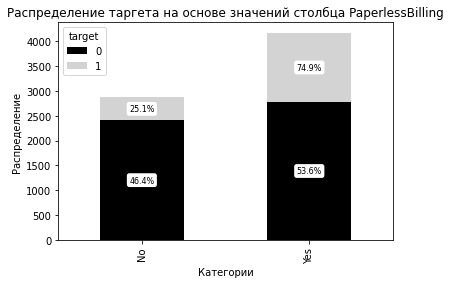

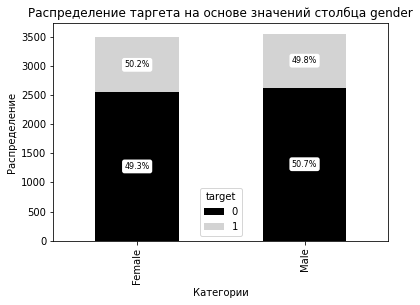

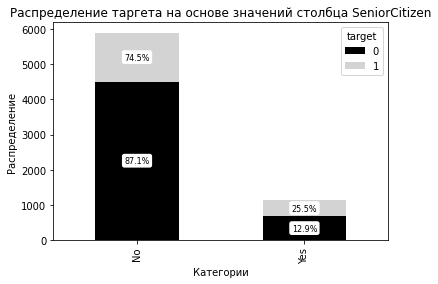

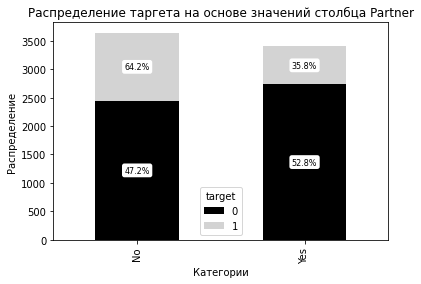

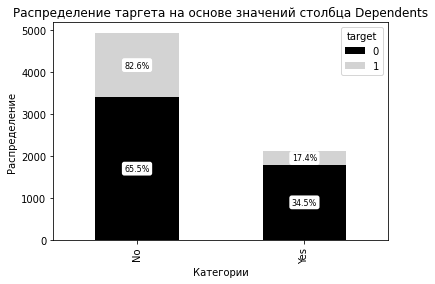

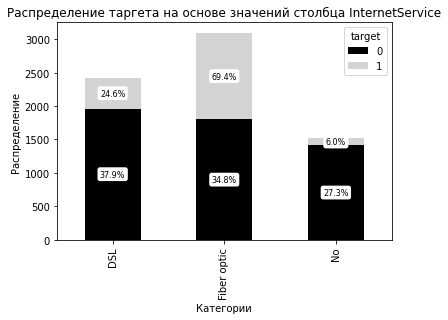

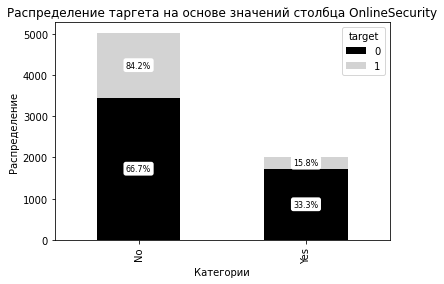

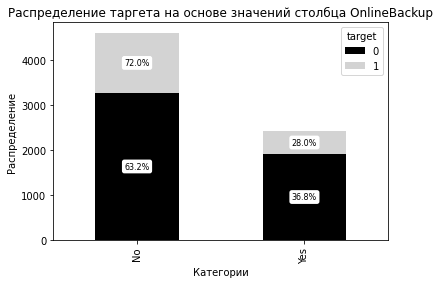

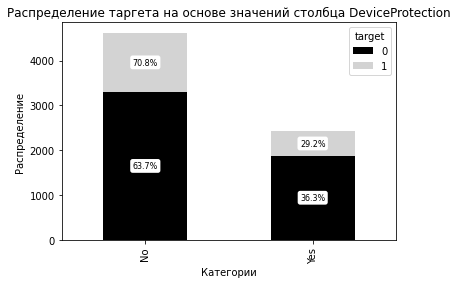

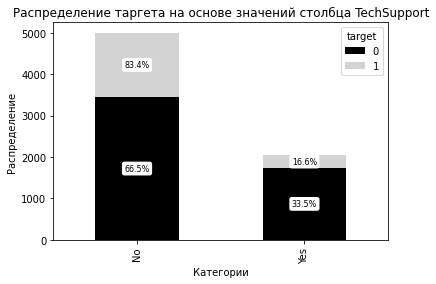

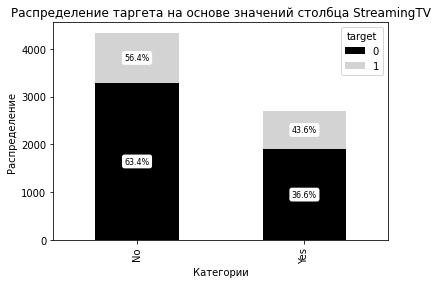

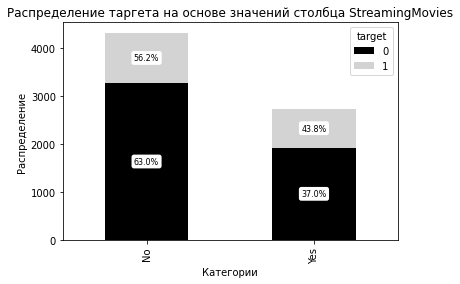

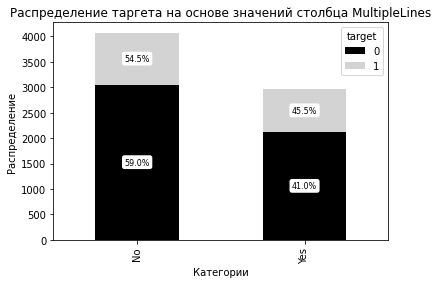

In [57]:
for column in categories_list:
    plot_target_distribution(base_df, column)

Создадим списки признаков для кодирования, один, категориальный у нас уже есть <b>categories_list</b>

In [58]:
numerical_list = ['MonthlyCharges', 'TotalCharges', 'duration_contract']

In [59]:
test = base_df.phik_matrix(interval_cols=numerical_list)

In [60]:
display(test)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,duration_contract
Type,1.000000,0.106860,0.277462,0.388444,0.505826,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.251639,0.037860
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.207127,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.295754,0.050069
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.350566,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.449125,0.000868
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.762839,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.360050,0.015962
TotalCharges,0.505826,0.207127,0.350566,0.762839,1.000000,0.000000,0.149384,0.424467,0.119077,0.508222,0.545067,0.653989,0.671714,0.566062,0.660753,0.666609,0.606117,0.278498,0.017197
gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.149384,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.233432,0.034522
Partner,0.179736,0.013218,0.243008,0.203545,0.424467,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.232930,0.016432
Dependents,0.147680,0.172593,0.224903,0.184366,0.119077,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.253936,0.035546
InternetService,0.505187,0.231438,0.323886,0.919002,0.508222,0.000000,0.160702,0.000000,0.108463,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.225383,0.196202,0.030204


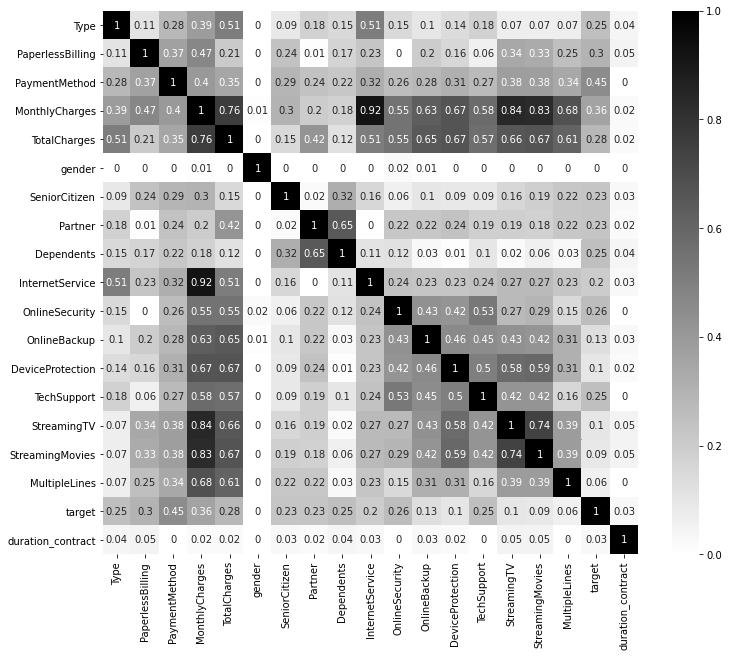

In [61]:
plt.figure(figsize=(12, 10))
sns.heatmap(test.copy().round(2), cmap="binary", annot=True);

In [62]:
base_df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'target', 'duration_contract'],
      dtype='object')

In [63]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   object 
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   TotalCharges       7043 non-null   float64
 5   gender             7043 non-null   object 
 6   SeniorCitizen      7043 non-null   object 
 7   Partner            7043 non-null   object 
 8   Dependents         7043 non-null   object 
 9   InternetService    7043 non-null   object 
 10  OnlineSecurity     7043 non-null   object 
 11  OnlineBackup       7043 non-null   object 
 12  DeviceProtection   7043 non-null   object 
 13  TechSupport        7043 non-null   object 
 14  StreamingTV        7043 non-null   object 
 15  StreamingMovies    7043 non-null   object 
 16  MultipleLines      7043 

## Подготовка для обучения

Разделим на целевой и остальные признаки

In [64]:
#features = base_df.drop('target', axis=1)
features = base_df[['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration_contract']]
target = base_df['target']

In [65]:
numerical_list = ['MonthlyCharges', 'TotalCharges', 'duration_contract']
categories_list = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 
                   'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV', 'StreamingMovies', 'MultipleLines']

Используем <b>train_test_split</b> чтобы разделить выборки

In [66]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=.25,
    stratify=target,
    random_state=RANDOM_STATE
)

Посмотрим на результат разделения

In [67]:
features_train.shape

(5282, 17)

In [68]:
features_test.shape

(1761, 17)

In [69]:
target_train.shape

(5282,)

In [70]:
target_test.shape

(1761,)

Полезные функции

In [71]:
#Используем пайплайн
def build_pipeline(model, features_categories, features_numeric):
    column_trans = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), features_categories),
        ('std', PowerTransformer(), features_numeric),
    ], remainder='drop', verbose_feature_names_out=False)

    pipeline = Pipeline([
        ('transform', column_trans),
        ('clf', model)
    ])

    return pipeline

Подбор параметров для логистической регрессии

In [72]:
def get_logistic_regression_params():
    return {
        'clf__solver': ['liblinear', 'lbfgs'],
        'clf__C': [0.111, 0.5, 0.999]
    }

Подбор параметров для lgbm

In [73]:
def get_lgbm_classifier_params():
    return {
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [3, 5, 7],
    }

Подбор параметров для catboost

In [74]:
def get_catboost_classifier_params():
    return {
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__iterations': [50, 100, 200, 500],
        'clf__depth': [3, 5, 7],
    }

Функция для обучения модели с использованием кросс-валидации и поиска оптимальных параметров

In [75]:
def train_model(features_train, target_train, pipeline, param_grid):
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=4,
        scoring='roc_auc',
        error_score='raise',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(features_train, target_train)

    return grid

Функция для причесывания вида времени (секунды)

In [76]:
def format_seconds(seconds):
    minutes, seconds = divmod(seconds, 60)
    formatted_time = "{:.1f} секунд".format(seconds)
    
    if minutes > 0:
        formatted_time = "{} минут {}".format(int(minutes), formatted_time)
    
    return formatted_time

Функция для вывода результатов обучения модели, метрику ROC AUC, время обучения, параметры лучшей модели

In [77]:
def print_model_result(grid, data_time, model_name, process_print=False):
    result_table = pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score']]
    
    result_table_ = pd.DataFrame({
        'Параметр': ['Модель', 'ROC AUC', 'Время'],
        'Значение': [model_name, grid.best_score_, format_seconds(data_time)]
    })
    
    display(result_table_)
    
    if process_print:
        print('\n' + '='*50 + '\n')
        print(f"Результаты выбора параметров модели: {model_name}")
        display(result_table)
        
    print(f"{'-'*50}")

## Обучение модели

Зададим переменные для выбора лучшей модели

In [78]:
best_model_name = None
best_model_auc = 0.0

Объявим модели

In [79]:
models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_STATE, class_weights=[1, 1], verbose=0)
}

In [80]:
for model_name, model in models.items():
    
    pipeline = build_pipeline(model, categories_list, numerical_list)
    
    param_grid = {}

    if model_name == 'LogisticRegression':
        param_grid = get_logistic_regression_params()
    elif model_name == 'LGBMClassifier':
        param_grid = get_lgbm_classifier_params()
    elif model_name == 'CatBoostClassifier':
        param_grid = get_catboost_classifier_params()

    start_time = time.time()
    grid_result = train_model(features_train, target_train, pipeline, param_grid)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print_model_result(grid_result, elapsed_time, model_name, process_print=True)
    
    final_model = grid_result.best_estimator_
    
    #predict_proba = grid_result.predict_proba(features_train)[:, 1]
    predict_proba = final_model.predict_proba(features_train)[:, 1]
    
    roc_auc = roc_auc_score(target_train, predict_proba)

    if roc_auc > best_model_auc:
        best_model_auc = roc_auc
        best_model_name = model_name
        best_model = grid_result

Fitting 4 folds for each of 6 candidates, totalling 24 fits


,Параметр,Значение
0,Модель,LogisticRegression
1,ROC AUC,0.848122
2,Время,16.7 секунд




Результаты выбора параметров модели: LogisticRegression


,params,mean_test_score
0,"{'clf__C': 0.111, 'clf__solver': 'liblinear'}",0.847552
1,"{'clf__C': 0.111, 'clf__solver': 'lbfgs'}",0.847787
2,"{'clf__C': 0.5, 'clf__solver': 'liblinear'}",0.848026
3,"{'clf__C': 0.5, 'clf__solver': 'lbfgs'}",0.848122
4,"{'clf__C': 0.999, 'clf__solver': 'liblinear'}",0.848119
5,"{'clf__C': 0.999, 'clf__solver': 'lbfgs'}",0.848095


--------------------------------------------------
Fitting 4 folds for each of 27 candidates, totalling 108 fits


,Параметр,Значение
0,Модель,LGBMClassifier
1,ROC AUC,0.84749
2,Время,40 минут 28.2 секунд




Результаты выбора параметров модели: LGBMClassifier


,params,mean_test_score
0,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.798533
1,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.798516
2,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.798527
3,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.822870
4,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.823351
5,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.826754
6,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.830080
7,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.831450
8,"{'clf__learning_rate': 0.001, 'clf__max_depth'...",0.833519
9,"{'clf__learning_rate': 0.01, 'clf__max_depth':...",0.812701


--------------------------------------------------
Fitting 4 folds for each of 36 candidates, totalling 144 fits


,Параметр,Значение
0,Модель,CatBoostClassifier
1,ROC AUC,0.848845
2,Время,3 минут 34.8 секунд




Результаты выбора параметров модели: CatBoostClassifier


,params,mean_test_score
0,"{'clf__depth': 3, 'clf__iterations': 50, 'clf_...",0.832492
1,"{'clf__depth': 3, 'clf__iterations': 50, 'clf_...",0.834798
2,"{'clf__depth': 3, 'clf__iterations': 50, 'clf_...",0.847402
3,"{'clf__depth': 3, 'clf__iterations': 100, 'clf...",0.832102
4,"{'clf__depth': 3, 'clf__iterations': 100, 'clf...",0.838704
5,"{'clf__depth': 3, 'clf__iterations': 100, 'clf...",0.848129
6,"{'clf__depth': 3, 'clf__iterations': 200, 'clf...",0.833013
7,"{'clf__depth': 3, 'clf__iterations': 200, 'clf...",0.843208
8,"{'clf__depth': 3, 'clf__iterations': 200, 'clf...",0.844405
9,"{'clf__depth': 3, 'clf__iterations': 500, 'clf...",0.835882


--------------------------------------------------


### Вывод

Все модели показали +\- одинаковые показатели, но CatBoostClassifier чуть лучше, поэтому протестируем эту модель 

In [81]:
best_model.best_params_

{'clf__depth': 5, 'clf__iterations': 500, 'clf__learning_rate': 0.01}

In [82]:
best_model.best_score_

0.8488450807497199

In [115]:
best_estimator = grid_result.best_estimator_
best_estimator

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Type', 'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines']),
                                                 ('std', PowerTransformer(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'duration_contract'])],
                                   verbose_feature_names_out=False)),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7ff77c9ff5b0>)])

## Тестирование модели

Прогноз вероятностей с использованием лучшей модели

In [83]:
predict_proba_best = best_model.predict_proba(features_test)[:, 1]

Вычисление характеристик ROC-кривой (False Positive Rate, True Positive Rate, пороги) на основе предсказанных вероятностей и истинных меток тестового набора

In [84]:
fpr_best, tpr_best, thresholds_best = roc_curve(target_test, predict_proba_best)

Вычисление площади под ROC-кривой (AUC-ROC) на основе полученных значений FPR и TPR

In [85]:
roc_auc_best = auc(fpr_best, tpr_best)

Построим график

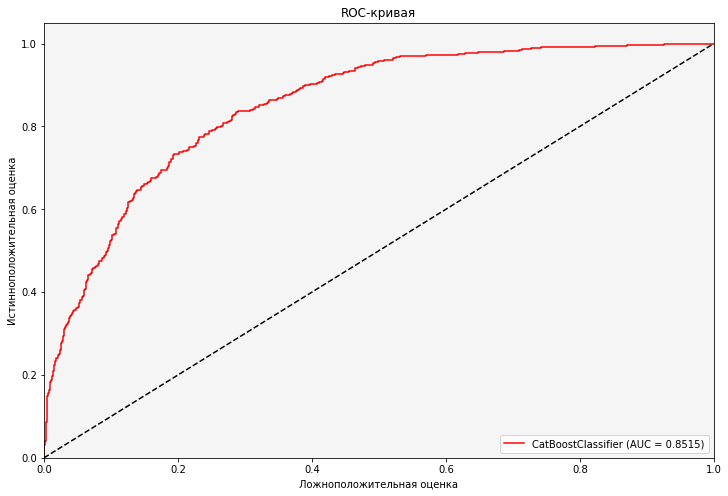

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_facecolor('whitesmoke')

ax.plot(
    fpr_best,
    tpr_best,
    color='red',
    label=f'{best_model_name} (AUC = {roc_auc_best:.4f})'
)
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Ложноположительная оценка')
ax.set_ylabel('Истинноположительная оценка')
ax.set_title('ROC-кривая')
ax.legend(loc="lower right")
plt.show()


# Матрица ошибок CBC

Установка порога для преобразования вероятностей в бинарные предсказания

In [87]:
threshold = 0.5

Преобразование предсказанных вероятностей в бинарные предсказания с использованием установленного порога

In [88]:
binary_predictions = (predict_proba_best > threshold).astype(int)

Вычисление матрицы ошибок для лучшей модели на основе бинарных предсказаний и истинных меток тестового набора

In [89]:
cm_best = confusion_matrix(target_test, binary_predictions)

Создание DataFrame для удобного использования в визуализации

In [90]:
cm_best_data = pd.DataFrame(cm_best,
                            index=['0', '1'],
                            columns=['0', '1'])

Визуализируем

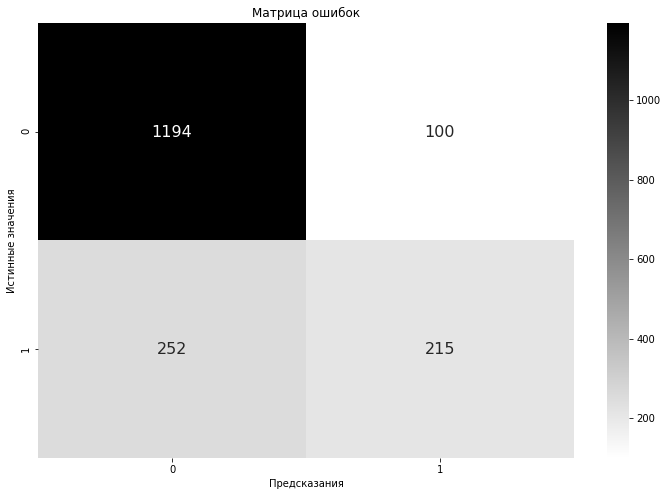

In [91]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm_best_data, xticklabels=cm_best_data.columns, yticklabels=cm_best_data.index, annot=True, fmt='g', cmap="binary", annot_kws={"size": 16})
plt.title("Матрица ошибок")
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.show()

Объединение имен числовых и категориальных признаков в один список

In [163]:
feature_names = numerical_list + categories_list

Извлечение значимости признаков из лучшей модели, полученной в результате обучения

In [164]:
feature_importances = best_estimator.named_steps['clf'].feature_importances_

Закодированные признаки

In [165]:
additional_features = len(feature_importances) - len(feature_names)

In [166]:
numerical_and_categories_list = feature_names + [f'additional_feature_{i}' for i in range(1, additional_features + 1)]

Создание DataFrame для хранения значимости признаков с соответствующими именами признаков, затем сортировка его по убыванию значимости

In [167]:
feature_importance = pd.DataFrame({'feature': numerical_and_categories_list, 
                      'importance': feature_importances}).sort_values('importance', ascending=False)

Установка столбца с именами признаков в качестве индекса DataFrame для более удобного отображения

In [168]:
feature_importance.set_index('feature', inplace=True)

Отображение топ-10 признаков и их значимостей

In [169]:
display(feature_importance.head(10))

,importance
feature,
TotalCharges,21.581764
additional_feature_3,21.470725
InternetService,11.936749
MonthlyCharges,7.903221
additional_feature_2,7.740936
OnlineSecurity,5.957204
additional_feature_4,3.758210
PaperlessBilling,3.753931
MultipleLines,3.020518


Визуализируем

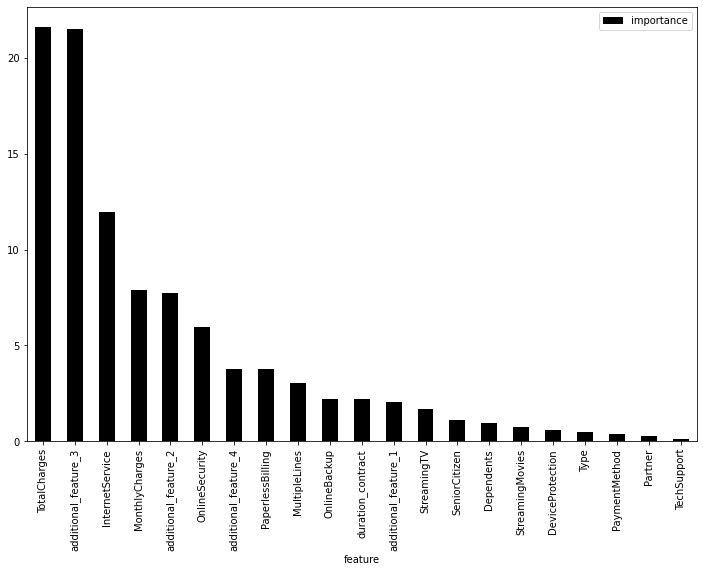

In [170]:
feature_importance.plot.bar(color='black', figsize=(12, 8));

## Вывод

Задача данного проекта успешно выполнена, и для более эффективного прогнозирования оттока клиентов компании "ТелеДом" в рабочей среде рекомендуется внедрить модель машинного обучения <b>CatBoostClassifier</b>. В процессе тестирования данная модель продемонстрировала высокую эффективность, выраженную значением показателя ROC AUC, равным <code>0.85</code>. Этот результат подтверждает надежность и точность модели при анализе потенциального оттока клиентов.